In [127]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re
import cv2
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as pltPolygon
import pandas as pd


def get_omnipose_mask_dict(filename: str):
    mask_dict = {}
    npzFiles = glob.glob(filename)
    for filename in npzFiles:
        img = Image.open(filename)
        img = img.convert('L')
        mask = np.array(img) 

        pattern = r't(\d+)'
        match = re.search(pattern, filename)

        if match:
            t_value = match.group(1)
            t_with_prefix = 't' + t_value
        else:
            raise Exception("No time prefix match found.")
        
        mask_dict[t_with_prefix] = mask

    return mask_dict

def get_polygon_2d_dict(filename: str, threshold = 5):
    mask_dict = get_omnipose_mask_dict(filename)
    polygons_dict = {}
    for key, mask in mask_dict.items():
        polygons_dict[key]= mask_matrix_to_ploygon_list(mask, threshold=threshold)

    return polygons_dict


def mask_matrix_to_ploygon_list(mask, threshold = 0):
    frame_dict={}
    for i in range(1,np.max(mask)+1):
        if np.sum(mask == i) > threshold:
            cell_mask = mask == i 
            cell_mask = ( cell_mask  * 255).astype(np.uint8)
            contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours]
            assert len(polygons) == 1 , "Disconnected multi-pieces found on single mask/cell label"
            frame_dict[i] = polygons[0]
    
    return frame_dict


def get_cell_info_by_mask(labels_mask):
    label_info_df = pd.DataFrame(columns = ['label', 'x_mean', 'y_mean', 'area'])
    regs_label = labels_mask
    for i in range(1,np.max(regs_label)+1):
        row_indices, col_indices = np.where(regs_label == i)
        if len(row_indices) > 0:
            new_row = {'label': i, 'x_mean': np.average(col_indices), 'y_mean': np.average(row_indices), 'area': len(row_indices)}
            label_info_df.loc[len(label_info_df)] = new_row

    return label_info_df


def get_cell_info_by_ploygon(frame_polygons_dict):
    label_info_df = pd.DataFrame(columns = ['label', 'x_mean', 'y_mean', 'area'])
    for key, value in frame_polygons_dict.items():
        # value should in Shaply polygon class
        new_row = {'label': key, 'x_mean': value.centroid.x, 'y_mean': value.centroid.y, 'area':value.area}
        label_info_df.loc[len(label_info_df)] = new_row

    return label_info_df



In [128]:
import pandas as pd
from scipy.io import savemat
import numpy as np
import glob
import os
import re
from scipy.io import loadmat
import pandas as pd


def get_manual_link_dict(excel_path ):
    assert excel_path.endswith('.xlsx'), "File must be an Excel file with a .xlsx extension"

    excel_file = pd.ExcelFile(excel_path)
    sheet_names = excel_file.sheet_names

    manual_link_master_dict = {}
    for time_sheet in sheet_names:
        df = excel_file.parse(time_sheet)
        df = df.astype(str)
        [source, target] = df.columns

        target_max_id = 0
        source_max_id = 0

        time_dict = {}
       
        for index, row in df.iterrows():
            try:
                mother = int(row[source])
            except ValueError:
                mother = 0
            daughter = row[target].lower()
            if 'x' in daughter:
                cell_list = [0]
            else:
                cell_list = daughter.split(',')

            time_dict[mother] = {int(x) for x in cell_list}
            target_max_id = max(np.max(list(time_dict[mother])), target_max_id)
            source_max_id = max(mother, source_max_id)

        manual_link_master_dict[time_sheet] = linking_dict_to_linking_matrix(time_dict)

        return manual_link_master_dict


def get_supersegger_file_info_and_tracker_result_new(foldername):
    npzFiles = glob.glob(foldername)
    supperSegger_dict = {}

    for f in npzFiles:
        pattern = r't(\d+)'
        match = re.search(pattern, f)

        if match:
            time_value = int(match.group(1)) 
            frame_index = f"t{time_value:05d}"
        else:
            raise ValueError('No time prefix on filename.')

        data = loadmat(f)
        label = data['regs']['regs_label'][0][0]
        track_result = data['regs']['map'][0][0]['f'][0][0][0]
        
        track_dict = {}
        for i in range(len(track_result)):
            if len(track_result[i][0]) > 0:
               track_dict[i+1] = set(track_result[i][0])
        
        #Last frame don't have linking array
        if len(track_dict) == 0 :
            continue

        supperSegger_dict[frame_index] = linking_dict_to_linking_matrix(track_dict)

    return supperSegger_dict


def linking_dict_to_linking_matrix(dict):
    source_max_id = np.max(list(dict.keys()))
    flattened_values = [item for value_set in dict.values() for item in value_set]
    target_max_id = max(flattened_values)

    matrix = np.zeros((source_max_id+1, target_max_id+1))

    for key, value in dict.items():
        for item in value:
            matrix[key][item] = 1
    
    return matrix

def autolabel_brith_death():
    # TODO implement this 
    pass

In [217]:
import warnings

def match_trackmate_cell_id_to_mask_label(spots_filename, mask_foldername, UNIT_CONVERT_COEFF = 1):

    # Read top 4 line as header by trackmate dataformat
    spots = pd.read_csv(spots_filename, header=[0, 1, 2, 3])
    # Only use the first row header for convenient
    spots.columns = spots.columns.get_level_values(0)

    mask_polygons_dict = get_polygon_2d_dict(mask_foldername)
    assert len(mask_polygons_dict) == np.max(spots["FRAME"])+1, "The number of masks and trackmate frame number is inconsist,  contents of folders don't match up"
    sorted_polygon_frame_key = sorted(mask_polygons_dict)

    trackmate_frame_index = spots["FRAME"].unique()
    trackmate_frame_index.sort()

    label_correlated_dic = {}

    for frame in trackmate_frame_index:
        cells_in_frame = spots[spots["FRAME"] == frame]
        mask_filename_time_index = sorted_polygon_frame_key[frame]
        mask_cells = get_cell_info_by_ploygon(mask_polygons_dict[ mask_filename_time_index ])
        for index, row in cells_in_frame.iterrows():
            # Trackmate using timeframe start from 0
            cell_id = row["ID"]
            # Trackmate use different unit of position, check trackmate document / tracks excel 
            trackmate_x = row["POSITION_X"]*UNIT_CONVERT_COEFF
            trackmate_y = row["POSITION_Y"]*UNIT_CONVERT_COEFF

            candidates =  mask_cells.loc[ ((abs( mask_cells['x_mean'] - trackmate_x)  + abs( mask_cells['y_mean'] - trackmate_y)) < 2 ) ]

            # if matched candidates is not prefect 1 to 1, means the matching result could have some uncertainty, notify
            if len(candidates) == 0 or len(candidates) > 1:
                if len(candidates) == 0:
                    warnings.warn(f"Trackmate cell:{cell_id} match back to mask is inaccute, matching to the nearest cell!")
                else:
                    warnings.warn(f"Trackmate cell:{cell_id} around by dense cells, multiple candidates, matching to the nearest cell!")
                min_value = min(( mask_cells['x_mean'] - trackmate_x)**2 + ( mask_cells['y_mean'] - trackmate_y)**2)
                # Use boolean indexing to filter rows where the expression equals the minimum value
                label =  mask_cells.loc[(( mask_cells['x_mean'] - trackmate_x)**2 + ( mask_cells['y_mean'] - trackmate_y) ** 2) == min_value].iloc[0]['label']
            else:
                label = candidates.iloc[0]['label']

            spots.loc[index, "mask_label"] = int(label)
            spots.loc[index, "supersegger_time_index"] = mask_filename_time_index

    return spots


def abstract_trackmate_linking_result(spots_filename, edge_filename, mask_foldername):
    spots = match_trackmate_cell_id_to_mask_label(spots_filename, mask_foldername)
    track_dict =  abstact_tackmate_single_frame_assignment_matrix(spots, edge_filename, mask_foldername)
    return track_dict
    

def abstact_tackmate_single_frame_assignment_matrix(spots_df, edge_filename, mask_foldername):
    # Read top 4 line as header by trackmate dataformat
    tracks = pd.read_csv(edge_filename, header=[0, 1, 2, 3])
    # Only use the first row header for convenient
    tracks.columns =  tracks.columns.get_level_values(0)

    trackmate_track_index = tracks["EDGE_TIME"].unique()
    trackmate_track_index.sort()

    spots_reduced = spots_df[['ID', 'mask_label']]
    assert spots_reduced.isna().sum().sum() == 0
    spots_reduced['mask_label'] = pd.to_numeric(spots_reduced['mask_label'], errors='coerce').fillna(0).astype(int)

    tracks['mask_label'] = "" # for later suffixes convenient

    tracks = tracks.merge(
        spots_reduced[['ID', 'mask_label']],
        left_on='SPOT_SOURCE_ID',
        right_on='ID',
        suffixes=('', '_source')
    ).drop('ID', axis=1)

    # Second join on 'SPOT_TARGET_ID'
    tracks = tracks.merge(
        spots_reduced[['ID', 'mask_label']],
        left_on='SPOT_TARGET_ID',
        right_on='ID',
        suffixes=('', '_target')
    ).drop('ID', axis=1)

    tracks = tracks.drop('mask_label', axis=1)

    trackmate_linking_dict = {}
    for index in trackmate_track_index:
        frame_linking = tracks[tracks["EDGE_TIME"] == index]
        assignment_matrix = np.zeros((np.max(frame_linking["mask_label_source"]) + 1, np.max(frame_linking["mask_label_target"]) + 1))
        for key, row in frame_linking.iterrows():
            assignment_matrix[row["mask_label_source"]][row["mask_label_target"]] = 1
        trackmate_linking_dict[index] = assignment_matrix

    return trackmate_linking_dict


In [218]:
                    
spots_filename = "/Users/sherryyang/Documents/wiggins-lab/data/spots-simple.csv"
edge_filename = "/Users/sherryyang/Documents/wiggins-lab/data/tracks-simple.csv"
mask_foldername = "/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/masks/*.png"
trackmate_result = abstract_trackmate_linking_result(spots_filename, edge_filename, mask_foldername)

/var/folders/tp/1bsthy355yj6qlmh5ym1996w0000gn/T/ipykernel_38199/3175531610.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spots_reduced['mask_label'] = pd.to_numeric(spots_reduced['mask_label'], errors='coerce').fillna(0).astype(int)


In [241]:
super_seggerlink = get_supersegger_file_info_and_tracker_result_new("/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/seg/*err.mat")

In [237]:
import numpy as np

def compare_single_frame_matrix(matrix1, matrix2):
    # Determine the common shape
    common_shape = (min(matrix1.shape[0], matrix2.shape[0]), 
                    min(matrix1.shape[1], matrix2.shape[1]))

    # Slice both matrices to the common shape
    sub_matrix1 = matrix1[:common_shape[0], :common_shape[1]]
    sub_matrix2 = matrix2[:common_shape[0], :common_shape[1]]

    # Compare and count overlapping elements
    overlap_count = np.sum(sub_matrix1 * sub_matrix2)

     # Slice both matrices to the common shape
    sub_matrix1_inner = matrix1[1:common_shape[0], 1:common_shape[1]]
    sub_matrix2_inner = matrix2[1:common_shape[0], 1:common_shape[1]]

    # Compare and count overlapping elements
    overlap_count_without_born_death  = np.sum(sub_matrix1_inner * sub_matrix2_inner)
    
    return {"overlap": overlap_count,
            "left": np.sum(sub_matrix1), 
            "right": np.sum(sub_matrix2),  
            "overlap_pure_link": overlap_count_without_born_death,
            "left_pure_link": np.sum(sub_matrix1_inner),
            "right_pure_link": np.sum(sub_matrix2_inner),
            }


def compare_multiframe(dict1, dict2, only_link = True):
    assert len(dict1) == len(dict2), "Dimention of two assignment result dictionary not same "
    sorted_keys1 = sorted(dict1.keys())
    sorted_keys2 = sorted(dict2.keys())

    master_arr = np.zeros(len(dict1))

    for i in range(len(sorted_keys1)):
        assert isinstance(dict1[sorted_keys1[i]], np.ndarray)
        assert isinstance(dict2[sorted_keys2[i]], np.ndarray)
        result = compare_single_frame_matrix(dict1[sorted_keys1[i]], dict2[sorted_keys2[i]])
        if only_link:
            master_arr[i] = result["overlap"] * 1.0 / (result["left"] + result["right"] - result["overlap"])
        else:
            master_arr[i] = result["overlap_pure_link"] * 1.0 / (result["left_pure_link"] + result["right_pure_link"] - result["overlap_pure_link"])

    return master_arr


def compare_multiple_result(dict_of_multiple_assignment_dict, reference_dict):
    
    reference_length = len(reference_dict)

    master_dict = {}
    for key, value in dict_of_multiple_assignment_dict.items():
        # assert each assignment algo has same number frames
        assert len(value) == reference_length, f"Assignment {key} algo, have different number of frame than others" 
        master_dict[key] = compare_multiframe(value,reference_dict)
    
    return pd.DataFrame(master_dict)


In [ ]:
spots_filename = "/Users/sherryyang/Documents/wiggins-lab/data/spots-simple.csv"
edge_filename = "/Users/sherryyang/Documents/wiggins-lab/data/tracks-simple.csv"

mask_foldername = "/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/masks/*.png"

trackmate_result_lap = abstract_trackmate_linking_result(spots_filename, edge_filename, mask_foldername)


In [242]:
result_dict = {"trackmate": trackmate_result, "supersegger": super_seggerlink}
result  = compare_multiple_result(result_dict, trackmate_result)

<Axes: >

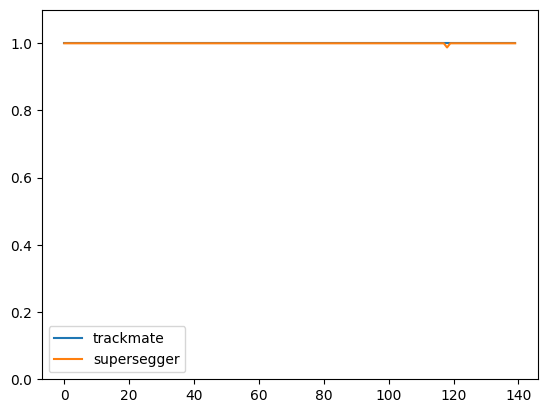

In [246]:
result.plot(ylim=(0, 1.1))

In [219]:
trackmate_result

{0.5: array([[0., 0.],
        [0., 1.]]),
 1.5: array([[0., 0.],
        [0., 1.]]),
 2.5: array([[0., 0.],
        [0., 1.]]),
 3.5: array([[0., 0.],
        [0., 1.]]),
 4.5: array([[0., 0.],
        [0., 1.]]),
 5.5: array([[0., 0.],
        [0., 1.]]),
 6.5: array([[0., 0.],
        [0., 1.]]),
 7.5: array([[0., 0.],
        [0., 1.]]),
 8.5: array([[0., 0.],
        [0., 1.]]),
 9.5: array([[0., 0.],
        [0., 1.]]),
 10.5: array([[0., 0.],
        [0., 1.]]),
 11.5: array([[0., 0.],
        [0., 1.]]),
 12.5: array([[0., 0.],
        [0., 1.]]),
 13.5: array([[0., 0.],
        [0., 1.]]),
 14.5: array([[0., 0.],
        [0., 1.]]),
 15.5: array([[0., 0.],
        [0., 1.]]),
 16.5: array([[0., 0.],
        [0., 1.]]),
 17.5: array([[0., 0.],
        [0., 1.]]),
 18.5: array([[0., 0.],
        [0., 1.]]),
 19.5: array([[0., 0.],
        [0., 1.]]),
 20.5: array([[0., 0.],
        [0., 1.]]),
 21.5: array([[0., 0.],
        [0., 1.]]),
 22.5: array([[0., 0.],
        [0., 1.]])

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Setup process
original_cell_index = 0
generation_dic = {}
G = nx.Graph()
pos = {}

df = excel_file.parse('t1-t2')
df = df.astype(str)
columns = df.columns
for index, row in df.iterrows():
    label1 = row[columns[0]] + columns[0]
    pos[label1] = (index,0)
    generation_dic[label1] = 1
    original_cell_index = index

# Normal process
for time_sheet in sheet_names:
        df = excel_file.parse(time_sheet)
        df = df.astype(str)
        columns = df.columns
        for index, row in df.iterrows():
            if ',' in row[columns[1]]:
                label1 = row[columns[0]] + columns[0]
                value = generation_dic[label1]
                (position, level) = pos[label1]
                
                cell_list = row[columns[1]].split(',')
                for index, cell in enumerate(cell_list):
                    label = cell + columns[1]
                    leftboundry = position - 1/(2*value)
                    offeset = 1/(value * len(cell_list)) * index + 1/(value * len(cell_list) * 2) 
                    pos[label] = (leftboundry + offeset,level-1)
                    generation_dic[label] = value * len(cell_list)
                    G.add_edge(label1, label)
            else:
                label2 = row[columns[1]] + columns[1]
                if row[columns[0]] == 'x':
                    print("hi")
                    original_cell_index += 1
                    position = original_cell_index 
                    new_level = -1 * int(columns[0][1:])
                    value = 1
                else:
                    label1 = row[columns[0]] + columns[0]
                    G.add_edge(label1, label2)
                    (position, level) = pos[label1]
                    value = generation_dic[label1]
                    new_level = level -1

                pos[label2] = (position,new_level)
                generation_dic[label2] = value